# Recommender System - Baseline Model
This notebook implements a simple baseline which is collaborative filtering Matrix Factorization.

In [2]:
import os
import math
import random
import numpy as np
import pandas as pd
import time
import gc
import matplotlib.pyplot as plt
from collections import defaultdict

# os.environ["HF_HOME"] = "D:/Python Projects/recommendation_system"
# os.environ["HF_DATASETS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/data"
# os.environ["TRANSFORMERS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/models"

os.environ["HF_HOME"] = "E:/Python Scripts/recsys"
os.environ['HF_DATASETS_CACHE'] = "E:/Python Scripts/recsys/data"
os.environ['TRANSFORMERS_CACHE'] = "E:/Python Scripts/recsys/models"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from recommenders.datasets.python_splitters import (
    python_chrono_split, python_stratified_split, python_random_split
)

from datasets import load_dataset, Features, Value
from tqdm import tqdm
from tensorboardX import SummaryWriter

E:\Python Scripts\recsys\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


## Loading the dataset
The dataset is loaded from the Hugging Face datasets library, Amazon Reviews 2023.

In [4]:
USE_HF = True
HF_DATASET = "McAuley-Lab/Amazon-Reviews-2023"
HF_DOMAIN = "Movies_and_TV"   # choose your domain

def load_amazon_reviews_fast(domain: str, max_items: int | None = None, seed: int = SEED) -> pd.DataFrame:
    ds = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        f"raw_review_{domain}",
        split="full",
        trust_remote_code=True,
    )

    # Keep only needed columns early
    ds = ds.select_columns(["user_id", "parent_asin", "rating", "verified_purchase", "timestamp"])

    # Rename + cast in Arrow (vectorized; no Python loop)
    ds = ds.rename_columns({"user_id": "user", "parent_asin": "item"})
    ds = ds.cast(Features({
        "user": Value("string"),
        "item": Value("string"),
        "rating": Value("float32"),
        "verified_purchase": Value("bool"),
        "timestamp": Value("int64"),   # seconds or ms as stored
    }))

    # Fast random subset without building a huge pandas frame first
    if max_items is not None:
        k = min(max_items, ds.num_rows)
        ds = ds.shuffle(seed=seed).select(range(k))

    # Convert to pandas (Arrow zero-copy where possible)
    df = ds.to_pandas()   # much faster than manual row loop
    df.insert(3, "domain", domain)  # add domain column to match your schema
    return df

# usage
df = load_amazon_reviews_fast(HF_DOMAIN, max_items=None, seed=SEED)
print(f"Loaded {len(df)} rows from {HF_DOMAIN} domain.")

Loaded 17328314 rows from Movies_and_TV domain.


In [6]:
df.head()

,user,item,rating,domain,verified_purchase,timestamp
0,AGGZ357AO26RQZVRLGU4D4N52DZQ,B013488XFS,5.0,Movies_and_TV,True,1440385637000
1,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B00CB6VTDS,5.0,Movies_and_TV,True,1461100610000
2,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,B096Z8Z3R6,3.0,Movies_and_TV,True,1646271834582
3,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,B09M14D9FZ,4.0,Movies_and_TV,False,1645937761864
4,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,B001H1SVZC,5.0,Movies_and_TV,True,1590639227074


## Preprocessing the dataset
- Make it implicit by considering all ratings as positive interactions.
- Filter out users and items with less than 5 interactions.
- Create a mapping of user and item IDs to indices.

In [8]:
# Make implicit dataset, filter users/items with less than 5 interactions, and encode user/item IDs
def preprocess_dataset(df, min_user_interactions=5, min_item_interactions=5):
    # Make it implicit
    df["label"] = 1.0

    # Filter users and items with less than 5 interactions
    user_counts = df["user"].value_counts()
    item_counts = df["item"].value_counts()

    valid_users = user_counts[user_counts >= min_user_interactions].index
    valid_items = item_counts[item_counts >= min_item_interactions].index

    df = df[df["user"].isin(valid_users) & df["item"].isin(valid_items)].copy()
    print("After interactions filtering:", len(df), "rows,", df["user"].nunique(), "users,", df["item"].nunique(), "items")

    user_enc = LabelEncoder()
    item_enc = LabelEncoder()

    df["user_id"] = user_enc.fit_transform(df["user"])
    df["item_id"] = item_enc.fit_transform(df["item"])

    return {"filtered_df": df,
            "user_encoder": user_enc,
            "item_encoder": item_enc}

data_processor = preprocess_dataset(df, min_user_interactions=20, min_item_interactions=20)
filtered_df = data_processor["filtered_df"]

After interactions filtering: 2557292 rows, 75821 users, 114321 items


In [9]:
def calculate_data_sparsity(df):
    num_users = df["user"].nunique()
    num_items = df["item"].nunique()
    num_interactions = len(df)
    density = num_interactions / (num_users * num_items)
    sparsity = 1 - density

    print(f"Number of users: {num_users}")
    print(f"Number of items: {num_items}")
    print(f"Number of interactions: {num_interactions}")
    print(f"-" * 30)
    print(f"Interaction Matrix Density: {density:.4f}")
    print(f"Interaction Matrix Sparsity: {sparsity:.4f}")

calculate_data_sparsity(filtered_df)

Number of users: 75821
Number of items: 114321
Number of interactions: 2557292
------------------------------
Interaction Matrix Density: 0.0003
Interaction Matrix Sparsity: 0.9997


In [10]:
def loo_split(df, oversample_verified=False, oversample_factor=2):
    df = df.sort_values(["user_id", "timestamp"])
    train_rows, val_rows, test_rows = [], [], []
    for uid, group in df.groupby("user_id", sort=False):
        g = group.sort_values("timestamp")
        if len(g) < 5:
            train_rows.append(g)
            continue
        test_rows.append(g.iloc[[-1]])  # Last interaction as test
        val_rows.append(g.iloc[[-2]])    # Second last interaction as validation
        train_rows.append(g.iloc[:-2])    # All but last two as training

    train_df = pd.concat(train_rows, ignore_index=True)
    val_df = pd.concat(val_rows, ignore_index=True)
    test_df = pd.concat(test_rows, ignore_index=True)

    if oversample_verified and oversample_factor > 1:
        verified_rows = train_df.loc[train_df["verified_purchase"] == True]
        if not verified_rows.empty:
            train_df = pd.concat([train_df] + [verified_rows] * (oversample_factor - 1), ignore_index=True)

    return train_df, val_df, test_df

train_df, val_df, test_df = loo_split(filtered_df, oversample_verified=False, oversample_factor=1)
print(f"Train/Validation/Test split: {len(train_df)}, {len(val_df)}, {len(test_df)}")

Train/Validation/Test split: 2406272, 75510, 75510


## Building the dataset with negative sampling

In [11]:
NUM_USERS = filtered_df["user_id"].max() + 1
NUM_ITEMS = filtered_df["item_id"].max() + 1

In [12]:
# Rank the single positive against k negative samples for train and evaluation
def build_pos_items_by_user(train_df):
    pos_items_by_user = defaultdict(set)
    for u, i in zip(train_df["user_id"].values, train_df["item_id"].values):
        pos_items_by_user[u].add(int(i))
    return pos_items_by_user

In [22]:
# Training dataset with k negatives per positive
class ImplicitTrainingDataset(Dataset):
    def __init__(self, train_df, num_items, pos_by_user, neg_k=4, seed=SEED):
        self.pos_pairs = train_df[["user_id", "item_id"]].values.astype(np.int64)
        self.num_pos = len(self.pos_pairs)
        self.neg_k = neg_k
        self.num_items = num_items
        self.pos_by_user = pos_by_user
        self.length = self.num_pos * (1 + self.neg_k)
        self.rng = random.Random(seed)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        pos_idx = idx // (self.neg_k + 1)
        is_pos = (idx % (self.neg_k + 1) == 0)
        u, i_pos = self.pos_pairs[pos_idx]
        if is_pos:
            return int(u), int(i_pos), 1.0

        while True:
            j = self.rng.randint(0, self.num_items - 1)
            if j not in self.pos_by_user[u]:
                return int(u), int(j), 0.0

pos_items_by_user = build_pos_items_by_user(train_df)

train_dataset = ImplicitTrainingDataset(train_df,
                                  num_items=NUM_ITEMS,
                                  pos_by_user=pos_items_by_user,
                                  neg_k=4)
train_loader = DataLoader(train_dataset,
                          batch_size=4096,
                          shuffle=True)

print(f"Training dataset created with {len(train_dataset)} samples.")

Training dataset created with 12031360 samples.


In [23]:
class EvaluateDataset(Dataset):
    def __init__(self, eval_df, num_items, pos_by_user, n_neg=99, seed=42):
        self.users = eval_df["user_id"].values.astype(np.int64)
        self.pos_items = eval_df["item_id"].values.astype(np.int64)
        self.n_neg = n_neg
        self.num_items = num_items
        self.pos_by_user = pos_by_user

        rng = np.random.default_rng(seed)
        self.candidates = np.empty((len(self.users), 1 + n_neg), dtype=np.int64)

        for idx, (u, pos_i) in enumerate(zip(self.users, self.pos_items)):
            user_pos = pos_by_user[u].copy()
            user_pos.add(pos_i)
            negs = []
            while len(negs) < n_neg:
                neg = rng.integers(0, num_items)
                if neg not in user_pos:
                    negs.append(int(neg))
                    user_pos.add(neg)
            self.candidates[idx, 0] = pos_i
            self.candidates[idx, 1:] = np.asarray(negs, dtype=np.int64)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return int(self.users[idx]), self.candidates[idx]

# Build val/test loaders
val_dataset = EvaluateDataset(val_df, NUM_ITEMS, pos_items_by_user, n_neg=99, seed=SEED)
test_dataset = EvaluateDataset(test_df, NUM_ITEMS, pos_items_by_user, n_neg=99, seed=SEED)

val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)

print(f"Validation dataset: {len(val_dataset)} users")
print(f"Test dataset: {len(test_dataset)} users")

Validation dataset: 75510 users
Test dataset: 75510 users


## Utility functions for evaluation & ranking metrics
- For each val user, build candidate set = `{positive} U {k negatives}`
- Score, sort, compute HR@K, NDCG@K, Precision@K, Recall@K

In [24]:
# Validation loss and ranking metrics
@torch.no_grad()
def evaluate_ranking_loader(model, eval_loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = 0
    sum_hr = 0.0
    sum_ndcg = 0.0
    sum_prec = 0.0

    sum_val_loss = 0.0
    n_loss_batches = 0

    for users, cand in eval_loader:
        users = users.to(device, non_blocking=True)
        cand = torch.as_tensor(cand, dtype=torch.long, device=device)
        B, C = cand.shape

        # Repeat users per candidate, score in one forward
        users_rep = users.view(-1, 1).expand(-1, C).reshape(-1)
        items_flat = cand.reshape(-1)
        scores_flat = model(users_rep, items_flat)
        scores = scores_flat.view(B, C)

        # Rank of the positive (column 0)
        pos = scores[:, 0].unsqueeze(1)  # [B,1]
        # number of items with strictly greater score than the positive +1
        rank = (scores[:, 1:] > pos).sum(dim=1).add_(1).to(torch.long)  # [B]

        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)

        sum_hr += hit.sum().item()
        sum_ndcg += ndcg.sum().item()
        sum_prec += precision.sum().item()
        total += B

        # Validation loss: labels = [1, 0, 0, ...]
        labels = torch.zeros_like(scores)
        labels[:, 0] = 1.0
        batch_loss = loss_fn(scores, labels)
        sum_val_loss += batch_loss.item()
        n_loss_batches += 1

    metrics = {
        "HR@K": sum_hr / total if total else 0.0,
        "NDCG@K": sum_ndcg / total if total else 0.0,
        "Precision@K": sum_prec / total if total else 0.0,
        "Val loss": sum_val_loss / max(n_loss_batches, 1)
    }
    return metrics

## Train loop

In [25]:
def model_trainer(
        model,
        train_loader,
        eval_loader,
        epochs,
        loss_fn,
        optimizer,
        lr=0.001,
        k=10,             # kept to log hyperparams
        device="cpu",
        save_dir="model"
    ):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    writer = SummaryWriter()

    train_losses, val_losses, val_metrics_log = [], [], []
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        n_batches = 0
        t0 = time.time()

        for users, items, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            users = users.to(device, non_blocking=True)
            items = items.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            logits = model(users, items)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            n_batches += 1

        train_loss = running_loss / max(n_batches, 1)
        train_losses.append(train_loss)

        # Eval (batched)
        m = evaluate_ranking_loader(model, eval_loader, loss_fn, k=k, device=device)
        val_losses.append(m["Val loss"])
        val_metrics_log.append({k_: m[k_] for k_ in ["HR@K", "NDCG@K", "Precision@K"]})

        # Checkpointing by NDCG
        if m["NDCG@K"] > best_ndcg:
            best_ndcg = m["NDCG@K"]
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))

        # TB logs
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", m["Val loss"], epoch)
        writer.add_scalar(f"Metrics/Val_HR@{k}", m["HR@K"], epoch)
        writer.add_scalar(f"Metrics/Val_NDCG@{k}", m["NDCG@K"], epoch)
        writer.add_scalar(f"Metrics/Val_Precision@{k}", m["Precision@K"], epoch)

        print(
            f"Epoch {epoch+1}/{epochs}  "
            f"Train loss {train_loss:.4f}  "
            f"Val loss {m['Val loss']:.4f}  "
            f"HR@{k} {m['HR@K']:.4f}  "
            f"NDCG@{k} {m['NDCG@K']:.4f}  "
            f"Precision@{k} {m['Precision@K']:.4f}  "
            f"{'(new best)' if m['NDCG@K'] == best_ndcg and best_epoch==epoch+1 else ''}  "
            f"Time {time.time()-t0:.2f}s"
        )

    print("\n" + "="*50)
    print("Training Complete.")
    print(f"Best epoch: {best_epoch} with NDCG@{k}: {best_ndcg:.4f}")
    print("="*50)
    print("\n")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    writer.close()
    return train_losses, val_losses, val_metrics_log, best_ndcg

## Building baseline model

In [26]:
# Simple Matrix Factorization model (dot product)
class MatrixFactorization(nn.Module):
    """Improved MF model with dropout and better initialization"""
    def __init__(self, n_users, n_items, embedding_dim):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)

    def forward(self, user_ids, item_ids):
        user_embeds = self.user_embedding(user_ids)
        item_embeds = self.item_embedding(item_ids)
        dot_product = (user_embeds * item_embeds).sum(dim=1, keepdim=True)
        return dot_product.squeeze()

    def predict_all_items(self, user_id):
        """Predict scores for all items for a given user"""
        user_tensor = torch.tensor([user_id], dtype=torch.long).to(next(self.parameters()).device)
        all_items = torch.arange(self.item_embedding.num_embeddings).to(next(self.parameters()).device)
        user_embed = self.user_embedding(user_tensor)
        item_embeds = self.item_embedding(all_items)
        scores = torch.matmul(user_embed, item_embeds.T).squeeze()
        return torch.sigmoid(scores)

In [29]:
# Run the training
model = MatrixFactorization(n_users=NUM_USERS, n_items=NUM_ITEMS, embedding_dim=64).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses, val_losses, val_metrics, best_ndcg = model_trainer(
    model=model,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    k=10,
    device=DEVICE
)

Epoch 1/10: 100%|██████████| 2938/2938 [01:02<00:00, 47.33it/s]


Epoch 1/10  Train loss 0.5467  Val loss 0.3646  HR@10 0.3856  NDCG@10 0.2287  Precision@10 0.0386  (new best)  Time 65.13s


Epoch 2/10: 100%|██████████| 2938/2938 [01:01<00:00, 48.03it/s]


Epoch 2/10  Train loss 0.4482  Val loss 0.3530  HR@10 0.3956  NDCG@10 0.2358  Precision@10 0.0396  (new best)  Time 64.18s


Epoch 3/10: 100%|██████████| 2938/2938 [00:59<00:00, 49.47it/s]


Epoch 3/10  Train loss 0.4415  Val loss 0.3494  HR@10 0.4155  NDCG@10 0.2495  Precision@10 0.0416  (new best)  Time 62.43s


Epoch 4/10: 100%|██████████| 2938/2938 [01:03<00:00, 46.16it/s]


Epoch 4/10  Train loss 0.4343  Val loss 0.3461  HR@10 0.4320  NDCG@10 0.2619  Precision@10 0.0432  (new best)  Time 66.62s


Epoch 5/10: 100%|██████████| 2938/2938 [01:00<00:00, 48.71it/s]


Epoch 5/10  Train loss 0.4280  Val loss 0.3437  HR@10 0.4479  NDCG@10 0.2729  Precision@10 0.0448  (new best)  Time 63.31s


Epoch 6/10: 100%|██████████| 2938/2938 [01:00<00:00, 48.33it/s]


Epoch 6/10  Train loss 0.4229  Val loss 0.3417  HR@10 0.4608  NDCG@10 0.2812  Precision@10 0.0461  (new best)  Time 63.83s


Epoch 7/10: 100%|██████████| 2938/2938 [01:01<00:00, 47.60it/s]


Epoch 7/10  Train loss 0.4187  Val loss 0.3403  HR@10 0.4714  NDCG@10 0.2880  Precision@10 0.0471  (new best)  Time 64.74s


Epoch 8/10: 100%|██████████| 2938/2938 [01:00<00:00, 48.42it/s]


Epoch 8/10  Train loss 0.4152  Val loss 0.3386  HR@10 0.4778  NDCG@10 0.2934  Precision@10 0.0478  (new best)  Time 63.74s


Epoch 9/10: 100%|██████████| 2938/2938 [01:00<00:00, 48.57it/s]


Epoch 9/10  Train loss 0.4123  Val loss 0.3380  HR@10 0.4850  NDCG@10 0.2978  Precision@10 0.0485  (new best)  Time 63.58s


Epoch 10/10: 100%|██████████| 2938/2938 [01:03<00:00, 46.25it/s]


Epoch 10/10  Train loss 0.4102  Val loss 0.3371  HR@10 0.4886  NDCG@10 0.3001  Precision@10 0.0489  (new best)  Time 66.56s

Training Complete.
Best epoch: 10 with NDCG@10: 0.3001




In [30]:
def load_best_weights(model, ckpt_path="model/best_model.pth", device=None):
    """Load best checkpoint into the provided model."""
    if device is None:
        device = next(model.parameters()).device
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model

best_model = load_best_weights(model, ckpt_path="model/best_model.pth", device=DEVICE)

In [31]:
# Final evaluation on test set
@torch.no_grad()
def final_evaluation_loader(model, test_loader, loss_fn, k_values=(5,10,20,50), device="cpu") -> pd.DataFrame:
    rows = []
    for k in k_values:
        metrics = evaluate_ranking_loader(model, test_loader, loss_fn, k=k, device=device)
        rows.append({
            "K": k,
            "HR@K": metrics["HR@K"],
            "NDCG@K": metrics["NDCG@K"],
            "Precision@K": metrics["Precision@K"],
        })
    df = pd.DataFrame(rows).set_index("K").sort_index()
    print(df.to_string(float_format=lambda x: f"{x:.4f}"))
    return df

results_df = final_evaluation_loader(best_model, test_loader, loss_fn, device=DEVICE)

     HR@K  NDCG@K  Precision@K
K                             
5  0.3258  0.2310       0.0652
10 0.4472  0.2701       0.0447
20 0.5894  0.3060       0.0295
50 0.7995  0.3477       0.0160


In [32]:
@torch.no_grad()
def get_recommendations(
    model, user_id, pos_items_by_user, data, top_k=10, exclude_interacted=True, as_prob=False
):
    model.eval()
    scores = model.predict_all_items(user_id)  # logits
    if exclude_interacted and user_id in pos_items_by_user:
        idx = torch.as_tensor(list(pos_items_by_user[user_id]), dtype=torch.long, device=scores.device)
        if idx.numel() > 0:
            scores.index_fill_(0, idx, float('-inf'))

    top_scores, top_indices = torch.topk(scores, k=top_k)
    shown = torch.sigmoid(top_scores) if as_prob else top_scores

    item_ids_np = top_indices.detach().cpu().numpy()
    items_np = data["item_encoder"].inverse_transform(item_ids_np)
    return [{"item_id": int(i), "item": it, "score": float(s)} for i, it, s in zip(item_ids_np, items_np, shown.detach().cpu().numpy())]


In [33]:
def build_history_by_user(df):
    # df must contain user_id, item_id, timestamp (ints)
    df_sorted = df.sort_values(["user_id", "timestamp"])
    hist = defaultdict(list)
    for u, i in zip(df_sorted["user_id"].values, df_sorted["item_id"].values):
        hist[u].append(int(i))
    return hist

# Build once (choose train_df or filtered_df depending on story you want)
history_by_user_train = build_history_by_user(train_df)
history_by_user_full  = build_history_by_user(filtered_df)

In [34]:
def show_sample_recommendations(
    model,
    data,
    pos_items_by_user,     # pass train-only OR full here, same as get_recommendations
    history_by_user,       # pass the matching history dict (train or full)
    num_users=5,
    top_k=10
):
    print("\n" + "="*50)
    print("User Sample Recommendations")
    print("="*50)

    user_candidates = data["filtered_df"]["user_id"].unique().tolist()
    for user_id in random.sample(user_candidates, k=min(num_users, len(user_candidates))):
        original_user = data["user_encoder"].inverse_transform([user_id])[0]
        print(f"\nUser: {original_user} (ID: {user_id})")
        print("-" * 40)

        recent = history_by_user.get(user_id, [])[-5:]  # last 5 chronologically
        print("Recent interactions:")
        for item_id in reversed(recent):  # most recent first
            print("  -", data["item_encoder"].inverse_transform([item_id])[0])

        recs = get_recommendations(
            model,
            user_id=user_id,
            pos_items_by_user=pos_items_by_user,
            data=data,
            top_k=top_k,
            exclude_interacted=True
        )
        print("\nTop 10 Recommendations:")
        for i, rec in enumerate(recs, 1):
            print(f"  {i}. {rec['item']} (Score: {rec['score']:.4f})")

In [35]:
# “Online-style” (no future knowledge):
show_sample_recommendations(
    best_model,
    data_processor,
    pos_items_by_user=pos_items_by_user,     # exclude TRAIN-only
    history_by_user=history_by_user_train,
    num_users=5, top_k=10
)


User Sample Recommendations

User: AEVWNRJUL6JVTB4JGLCZDHPRU4BA (ID: 16582)
----------------------------------------
Recent interactions:
  - B06XT8YY5S
  - B01M5IPH1Q
  - B01MSYR5XO
  - B0748NJY1B
  - B01MDTXM2T

Top 10 Recommendations:
  1. B00RSGIVVO (Score: 0.9681)
  2. B00I3MQNWG (Score: 0.9655)
  3. B01J4SRJFW (Score: 0.9591)
  4. B01AB17IGQ (Score: 0.9566)
  5. B00MR9UY8A (Score: 0.9373)
  6. B003AZCYCE (Score: 0.9356)
  7. B00TU9UFTS (Score: 0.9277)
  8. B073RPZK88 (Score: 0.9268)
  9. B00YBX664Q (Score: 0.9233)
  10. B00H7NEXYC (Score: 0.9202)

User: AE4V454IAMIDG2PAPZOKQK6V2WVQ (ID: 1792)
----------------------------------------
Recent interactions:
  - B005HFLNDQ
  - B005HFLCSC
  - B008U4S6AE
  - B0191S92UU
  - B003AZCYCE

Top 10 Recommendations:
  1. B00RSGIVVO (Score: 0.9620)
  2. B01J4SRJFW (Score: 0.9507)
  3. B01AB17IGQ (Score: 0.9485)
  4. B00MR9UY8A (Score: 0.9267)
  5. B01EN8FBG2 (Score: 0.9099)
  6. B004MWZLYC (Score: 0.9096)
  7. B00H7NEXYC (Score: 0.9077)
  8. B0

In [36]:
def plot_training_history(train_losses, val_losses, val_metrics, save_path='training_history.png'):
    """Plot training history including train/val loss and metrics"""
    # Extract series
    hr_values = [m.get('HR@K', 0.0) for m in val_metrics]
    ndcg_values = [m.get('NDCG@K', 0.0) for m in val_metrics]
    precision_values = [m.get('Precision@K', 0.0) for m in val_metrics]

    fig = plt.figure(figsize=(18, 10))
    fig.suptitle('Training History', fontsize=16)

    gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.25)

    # 1) Loss plot
    ax_loss = fig.add_subplot(gs[0, 0])
    ax_loss.plot(train_losses, label='Training Loss', color='blue')
    ax_loss.plot(val_losses, label='Validation Loss', color='red')
    ax_loss.set_xlabel('Epoch'); ax_loss.set_ylabel('Loss'); ax_loss.set_title('Training vs Validation Loss')
    ax_loss.legend(); ax_loss.grid(True, alpha=0.3)

    # 2-4) Metric plots via loop
    metric_axes = [fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[1, 0])]
    metric_cfgs = [
        ('Val HR@10', hr_values, 'green', 'o', 'Validation Hit Rate@10', 'HR@10'),
        ('Val NDCG@10', ndcg_values, 'orange', 's', 'Validation NDCG@10', 'NDCG@10'),
        ('Val Precision@10', precision_values, 'purple', '^', 'Validation Precision@10', 'Precision@10'),
    ]
    for ax, (label, series, color, marker, title, ylabel) in zip(metric_axes, metric_cfgs):
        ax.plot(series, label=label, color=color, marker=marker)
        ax.set_xlabel('Epoch'); ax.set_ylabel(ylabel); ax.set_title(title)
        ax.legend(); ax.grid(True, alpha=0.3)

    # 5) All metrics together (span two columns)
    ax_all = fig.add_subplot(gs[1, 1:])
    for series, label, marker in [(hr_values, 'HR@10', 'o'),
                                  (ndcg_values, 'NDCG@10', 's'),
                                  (precision_values, 'Precision@10', '^')]:
        ax_all.plot(series, label=label, marker=marker)
    ax_all.set_xlabel('Epoch'); ax_all.set_ylabel('Score'); ax_all.set_title('All Validation Metrics Comparison')
    ax_all.legend(); ax_all.grid(True, alpha=0.3)

    fig.tight_layout(rect=(0, 0, 1, 0.96))
    fig.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()

C:\Users\super\AppData\Local\Temp\ipykernel_1624\3352965676.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 1, 0.96))


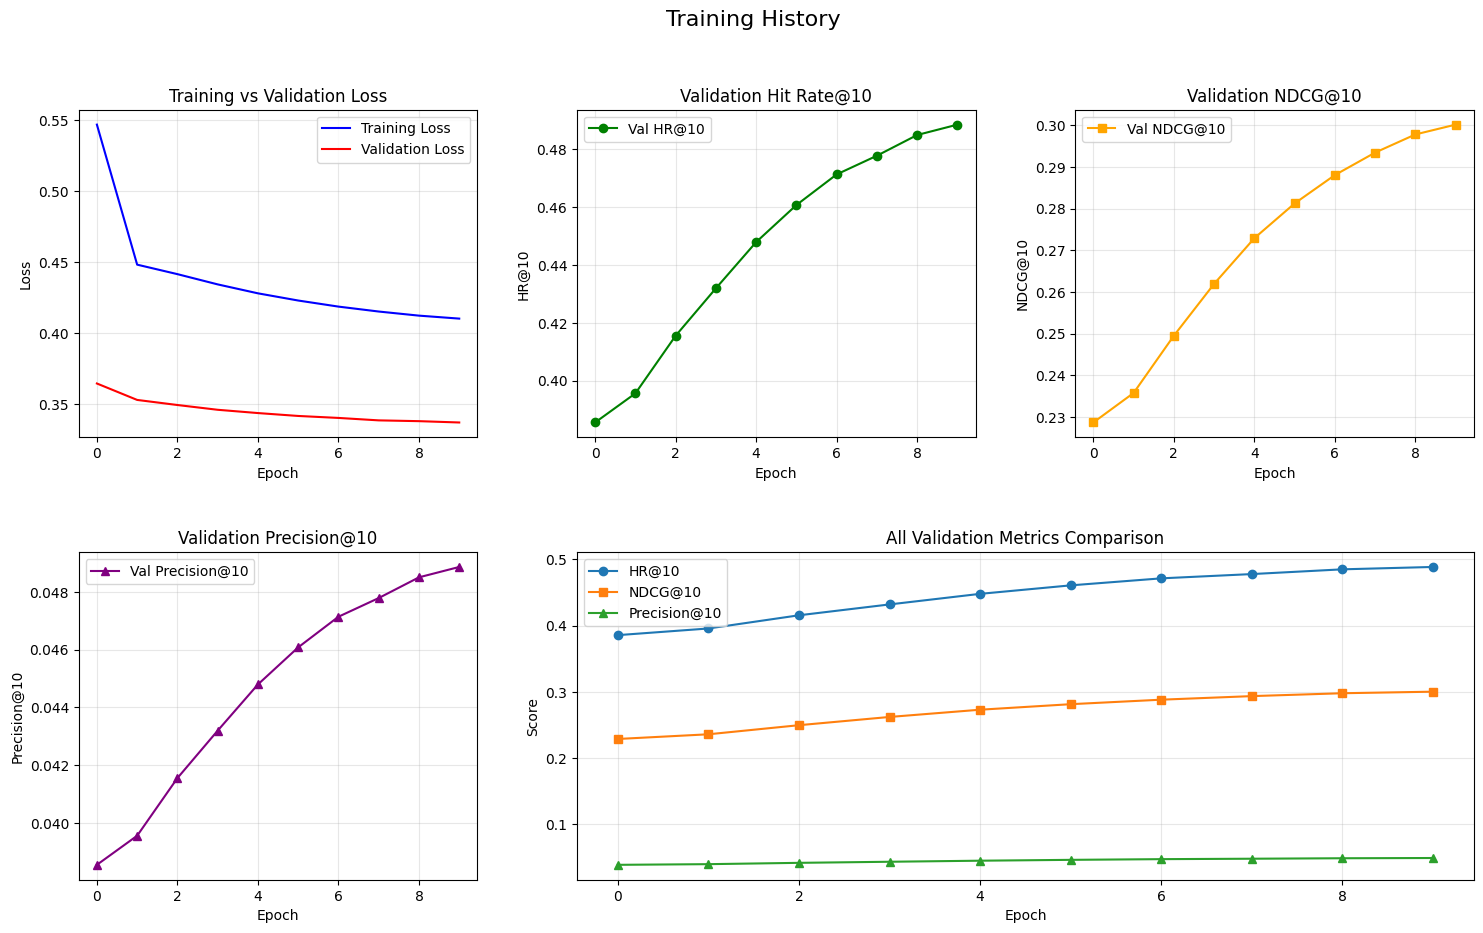

In [37]:
plot_training_history(train_losses, val_losses, val_metrics, save_path='training_history.png')

## Building NeuMF model

In [38]:
class NeuralMF(nn.Module):
    """
    NeuMF: GMF (dot-style) + MLP (nonlinear) with optional user/item/global biases.
    Returns raw logits suitable for BCEWithLogitsLoss.
    """
    def __init__(
        self,
        n_users: int,
        n_items: int,
        gmf_dim: int = 32,
        mlp_dim: int = 32,
        mlp_layers=(64, 32, 16),
        dropout: float = 0.1,
        use_bias: bool = True,
    ):
        super().__init__()
        # GMF branch
        self.user_emb_gmf = nn.Embedding(n_users, gmf_dim)
        self.item_emb_gmf = nn.Embedding(n_items, gmf_dim)

        # MLP branch
        self.user_emb_mlp = nn.Embedding(n_users, mlp_dim)
        self.item_emb_mlp = nn.Embedding(n_items, mlp_dim)

        mlp_blocks = []
        in_dim = mlp_dim * 2
        for h in mlp_layers:
            mlp_blocks.append(nn.Linear(in_dim, h))
            mlp_blocks.append(nn.ReLU())
            if dropout and dropout > 0:
                mlp_blocks.append(nn.Dropout(dropout))
            in_dim = h
        self.mlp = nn.Sequential(*mlp_blocks) if mlp_blocks else nn.Identity()

        # Final combine: concat(GMF, MLP) -> 1
        final_in = gmf_dim + (mlp_layers[-1] if mlp_blocks else mlp_dim * 2)
        self.fc_out = nn.Linear(final_in, 1)

        self.use_bias = use_bias
        if use_bias:
            self.user_bias = nn.Embedding(n_users, 1)
            self.item_bias = nn.Embedding(n_items, 1)
        else:
            self.user_bias = None
            self.item_bias = None
        self.global_bias = nn.Parameter(torch.zeros(1))

        self._reset_parameters()

    def _reset_parameters(self):
        for emb in [self.user_emb_gmf, self.item_emb_gmf, self.user_emb_mlp, self.item_emb_mlp]:
            nn.init.xavier_uniform_(emb.weight)
        for m in self.mlp:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        nn.init.xavier_uniform_(self.fc_out.weight)
        nn.init.zeros_(self.fc_out.bias)
        if self.use_bias:
            nn.init.zeros_(self.user_bias.weight)
            nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids):
        # GMF
        gmf_u = self.user_emb_gmf(user_ids)           # [B, gmf_dim]
        gmf_i = self.item_emb_gmf(item_ids)           # [B, gmf_dim]
        gmf   = gmf_u * gmf_i                         # [B, gmf_dim]  (element-wise product)

        # MLP
        mlp_u = self.user_emb_mlp(user_ids)           # [B, mlp_dim]
        mlp_i = self.item_emb_mlp(item_ids)           # [B, mlp_dim]
        mlp   = torch.cat([mlp_u, mlp_i], dim=1)      # [B, 2*mlp_dim]
        mlp   = self.mlp(mlp)                          # [B, last_mlp_hidden]

        # Combine
        x = torch.cat([gmf, mlp], dim=1)              # [B, gmf_dim + last_mlp_hidden]
        logit = self.fc_out(x).squeeze(-1)            # [B]

        if self.use_bias:
            logit = logit + self.user_bias(user_ids).squeeze(-1) + self.item_bias(item_ids).squeeze(-1)
        logit = logit + self.global_bias
        return logit

    @torch.no_grad()
    def predict_all_items(self, user_id: int) -> torch.Tensor:
        """
        Vectorized scoring for all items; returns raw logits.
        """
        device = next(self.parameters()).device
        u = torch.tensor([user_id], dtype=torch.long, device=device)
        all_items = torch.arange(self.item_emb_gmf.num_embeddings, dtype=torch.long, device=device)

        # GMF
        gmf_u = self.user_emb_gmf(u)                          # [1, gmf_dim]
        gmf_i = self.item_emb_gmf(all_items)                  # [N, gmf_dim]
        gmf   = (gmf_u * gmf_i)                               # [N, gmf_dim]

        # MLP
        mlp_u = self.user_emb_mlp(u).expand(all_items.numel(), -1)  # [N, mlp_dim]
        mlp_i = self.item_emb_mlp(all_items)                         # [N, mlp_dim]
        mlp   = torch.cat([mlp_u, mlp_i], dim=1)                     # [N, 2*mlp_dim]
        mlp   = self.mlp(mlp)                                        # [N, last_mlp_hidden]

        x = torch.cat([gmf, mlp], dim=1)                             # [N, gmf_dim+last]
        logit = self.fc_out(x).squeeze(-1)                           # [N]

        if self.use_bias:
            logit = logit + self.user_bias(u).squeeze(-1) + self.item_bias(all_items).squeeze(-1)
        logit = logit + self.global_bias
        return logit

In [40]:
neumf = NeuralMF(
    n_users=NUM_USERS,
    n_items=NUM_ITEMS,
    gmf_dim=32,
    mlp_dim=32,
    mlp_layers=(64, 32, 16),
    dropout=0.2,
    use_bias=True
).to(DEVICE)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(neumf.parameters(), lr=1e-3, weight_decay=1e-6)  # a bit higher LR works well for NeuMF

train_losses_n, val_losses_n, val_metrics_n, best_ndcg_n = model_trainer(
    model=neumf,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    k=10,
    device=DEVICE,
    save_dir="model_neumf"
)

best_neumf = load_best_weights(neumf, ckpt_path="model_neumf/best_model.pth", device=DEVICE)

results_neumf = final_evaluation_loader(best_neumf, test_loader, loss_fn, device=DEVICE)

Epoch 1/10: 100%|██████████| 2938/2938 [01:14<00:00, 39.51it/s]


Epoch 1/10  Train loss 0.4246  Val loss 0.2001  HR@10 0.4393  NDCG@10 0.2649  Precision@10 0.0439  (new best)  Time 78.00s


Epoch 2/10: 100%|██████████| 2938/2938 [01:13<00:00, 40.19it/s]


Epoch 2/10  Train loss 0.3478  Val loss 0.1810  HR@10 0.5368  NDCG@10 0.3280  Precision@10 0.0537  (new best)  Time 76.41s


Epoch 3/10: 100%|██████████| 2938/2938 [01:11<00:00, 41.05it/s]


Epoch 3/10  Train loss 0.3111  Val loss 0.1716  HR@10 0.5637  NDCG@10 0.3464  Precision@10 0.0564  (new best)  Time 74.82s


Epoch 4/10: 100%|██████████| 2938/2938 [01:08<00:00, 42.61it/s]


Epoch 4/10  Train loss 0.2939  Val loss 0.1589  HR@10 0.5803  NDCG@10 0.3605  Precision@10 0.0580  (new best)  Time 72.20s


Epoch 5/10: 100%|██████████| 2938/2938 [01:12<00:00, 40.73it/s]


Epoch 5/10  Train loss 0.2814  Val loss 0.1612  HR@10 0.5923  NDCG@10 0.3712  Precision@10 0.0592  (new best)  Time 75.85s


Epoch 6/10: 100%|██████████| 2938/2938 [01:11<00:00, 41.21it/s]


Epoch 6/10  Train loss 0.2709  Val loss 0.1495  HR@10 0.6036  NDCG@10 0.3807  Precision@10 0.0604  (new best)  Time 74.70s


Epoch 7/10: 100%|██████████| 2938/2938 [01:09<00:00, 42.11it/s]


Epoch 7/10  Train loss 0.2614  Val loss 0.1553  HR@10 0.6177  NDCG@10 0.3913  Precision@10 0.0618  (new best)  Time 73.07s


Epoch 8/10: 100%|██████████| 2938/2938 [01:07<00:00, 43.27it/s]


Epoch 8/10  Train loss 0.2530  Val loss 0.1543  HR@10 0.6227  NDCG@10 0.3972  Precision@10 0.0623  (new best)  Time 71.18s


Epoch 9/10: 100%|██████████| 2938/2938 [01:08<00:00, 43.06it/s]


Epoch 9/10  Train loss 0.2448  Val loss 0.1467  HR@10 0.6295  NDCG@10 0.4035  Precision@10 0.0629  (new best)  Time 71.45s


Epoch 10/10: 100%|██████████| 2938/2938 [01:11<00:00, 40.82it/s]


Epoch 10/10  Train loss 0.2378  Val loss 0.1474  HR@10 0.6329  NDCG@10 0.4071  Precision@10 0.0633  (new best)  Time 75.40s

Training Complete.
Best epoch: 10 with NDCG@10: 0.4071


     HR@K  NDCG@K  Precision@K
K                             
5  0.4308  0.3123       0.0862
10 0.5627  0.3549       0.0563
20 0.7037  0.3906       0.0352
50 0.8884  0.4274       0.0178
